In [81]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import (StandardScaler, OneHotEncoder)
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score)
from warnings import filterwarnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [51]:
def nan_percentage_per_column(data):
    return ((data.isna().sum() / data.shape[0]) * 100)


def remove_harmful_columns(data): ## decided that any column has missing values more than 20% will be removed
    nan_percentages = nan_percentage_per_column(data)
    valid_columns = nan_percentages[nan_percentages <= 20].index
    return data[valid_columns]

In [52]:
def num_cols_info(data):
    data = data.select_dtypes(include=['number'])

    return data.describe()

In [83]:
def model_eval(model, y_true, data, data_type, model_type):
    y_pred = model.predict(data)

    MAE = mean_absolute_error(y_true, y_pred)
    MSE = mean_squared_error(y_true, y_pred)
    R2 = r2_score(y_true, y_pred)

    print(f"<{model_type} Model|{data_type} Data Evaluation>\n"
            f"Mean Absolute Error >> {MAE:.2f}\n"
            f"Mean Squared Error >> {MSE:.2f}\n"
            f"R-Squared Score >> {R2:.2f}\n\n")

    return MAE, MSE, R2

In [54]:
def Linear_Regressor(X_train, y_train):
    model = LinearRegression(fit_intercept=True)

    model.fit(X_train, y_train)

    return model


def KNN_Regressor(X_train, y_train):
    model = KNeighborsRegressor(n_neighbors=5)

    model.fit(X_train, y_train)

    return model

In [55]:
def preprocess_data(X_train, X_test):
    num_scaler = StandardScaler() ## [-1, 1] mean = 0 | var = 1
    cat_scaler = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

    num_data_cols = X_train.select_dtypes(["number"]).columns.to_list()
    cat_data_cols = X_train.select_dtypes(["object"]).columns.to_list()

    X_train[num_data_cols] = num_scaler.fit_transform(X_train[num_data_cols])
    X_test[num_data_cols] = num_scaler.transform(X_test[num_data_cols])

    X_train_encoded = pd.DataFrame(cat_scaler.fit_transform(X_train[cat_data_cols]),
                                columns=cat_scaler.get_feature_names_out(cat_data_cols))

    X_test_encoded = pd.DataFrame(cat_scaler.transform(X_test[cat_data_cols]),
                                columns=cat_scaler.get_feature_names_out(cat_data_cols))

    X_train = pd.concat([X_train[num_data_cols].reset_index(drop=True), X_train_encoded.reset_index(drop=True)], axis=1)
    X_test = pd.concat([X_test[num_data_cols].reset_index(drop=True), X_test_encoded.reset_index(drop=True)], axis=1)

    return X_train, X_test

In [56]:
def fill_missing_values(data): ## done through sklearn imputing
    num_imputer = SimpleImputer(strategy="mean")
    cat_imputer = SimpleImputer(strategy="most_frequent")

    num_data_cols = data.select_dtypes(["number"]).columns.to_list()
    cat_data_cols = data.select_dtypes(["object"]).columns.to_list()

    data[num_data_cols] = num_imputer.fit_transform(data[num_data_cols])
    data[cat_data_cols] = cat_imputer.fit_transform(data[cat_data_cols])

    return data

In [57]:
def prepare_data(data):
    y = data[["Customer_Satisfaction_After"]]
    X = data.drop(columns= ["Customer_Satisfaction_After"])

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=42) ## set seed

    return X_train, X_test, y_train, y_test

In [88]:
def visualize_performance(LR_MAE, LR_MSE, LR_R2, KNN_MAE, KNN_MSE, KNN_R2, data_type):
  models = ['Linear Regression', 'KNN Regressor']
  metrics = ['MAE', 'MSE', 'R²']
  data = np.array([
      [LR_MAE, LR_MSE, LR_R2],
      [KNN_MAE, KNN_MSE, KNN_R2],
  ])

  scaler = MinMaxScaler()
  normalized_data = scaler.fit_transform(data)
  normalized_data[:, :2] = 1 - normalized_data[:, :2]

  plt.figure(figsize=(8, 6))
  sns.heatmap(
      normalized_data,
      annot=data,
      fmt=".2f",
      cmap="coolwarm",
      xticklabels=metrics,
      yticklabels=models,
      cbar_kws={'label': 'Normalized Performance (0 to 1)'}
  )

  plt.title(f'Model Performance On {data_type}ing Heatmap (Normalized)', fontsize=14)
  plt.xlabel('Metrics', fontsize=12)
  plt.ylabel('Models', fontsize=12)
  plt.tight_layout()
  plt.show()

  print("HOTTER IS BETTER !!")

In [91]:
numerical_data = pd.read_csv("/content/drive/MyDrive/ML_PROJECT_DATA/Sales_with_NaNs_v1.3.csv")
numerical_data.head()

,Group,Customer_Segment,Sales_Before,Sales_After,Customer_Satisfaction_Before,Customer_Satisfaction_After,Purchase_Made
0,Control,High Value,240.548359,300.007568,74.684767,NaN,No
1,Treatment,High Value,246.862114,381.337555,100.000000,100.000000,Yes
2,Control,High Value,156.978084,179.330464,98.780735,100.000000,No
3,Control,Medium Value,192.126708,229.278031,49.333766,39.811841,Yes
4,NaN,High Value,229.685623,NaN,83.974852,87.738591,Yes


In [92]:
has_duplicates = numerical_data.duplicated().any()

In [93]:
print("Dataset Shape: ", numerical_data.shape)
print("Contains duplicates: ", has_duplicates)
print("Number of NAN vlaues:\n", numerical_data.isna().sum())

Dataset Shape:  (10000, 7)
Contains duplicates:  False
Number of NAN vlaues:
 Group                           1401
Customer_Segment                1966
Sales_Before                    1522
Sales_After                      767
Customer_Satisfaction_Before    1670
Customer_Satisfaction_After     1640
Purchase_Made                    805
dtype: int64


In [94]:
# numerical_data = remove_harmful_columns(numerical_data)
numerical_data = fill_missing_values(numerical_data)

In [95]:
print("Number of NAN vlaues:\n", numerical_data.isna().sum())

Number of NAN vlaues:
 Group                           0
Customer_Segment                0
Sales_Before                    0
Sales_After                     0
Customer_Satisfaction_Before    0
Customer_Satisfaction_After     0
Purchase_Made                   0
dtype: int64


In [96]:
X_train, X_test, y_train, y_test = prepare_data(numerical_data)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 6), (2000, 6), (8000, 1), (2000, 1))

In [97]:
X_train, X_test = preprocess_data(X_train, X_test)

print("Columns before preprocessing: ", numerical_data.columns.tolist())
print("Columns after preprocessing: ", X_train.columns.tolist() + y_train.columns.tolist())

Columns before preprocessing:  ['Group', 'Customer_Segment', 'Sales_Before', 'Sales_After', 'Customer_Satisfaction_Before', 'Customer_Satisfaction_After', 'Purchase_Made']
Columns after preprocessing:  ['Sales_Before', 'Sales_After', 'Customer_Satisfaction_Before', 'Group_Control', 'Group_Treatment', 'Customer_Segment_High Value', 'Customer_Segment_Low Value', 'Customer_Segment_Medium Value', 'Purchase_Made_No', 'Purchase_Made_Yes', 'Customer_Satisfaction_After']


In [98]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 10), (2000, 10), (8000, 1), (2000, 1))

In [99]:
LR_model = Linear_Regressor(X_train, y_train)
KNN_model = KNN_Regressor(X_train, y_train)

In [100]:
LR_MAE, LR_MSE, LR_R2 = model_eval(LR_model, y_train, X_train, "Train", "Linear Regression")
KNN_MAE, KNN_MSE, KNN_R2 = model_eval(KNN_model, y_train, X_train, "Train", "KNN Regressor")

<Linear Regression Model|Train Data Evaluation>
Mean Absolute Error >> 9.13
Mean Squared Error >> 134.46
R-Squared Score >> 0.51


<KNN Regressor Model|Train Data Evaluation>
Mean Absolute Error >> 8.04
Mean Squared Error >> 102.91
R-Squared Score >> 0.62




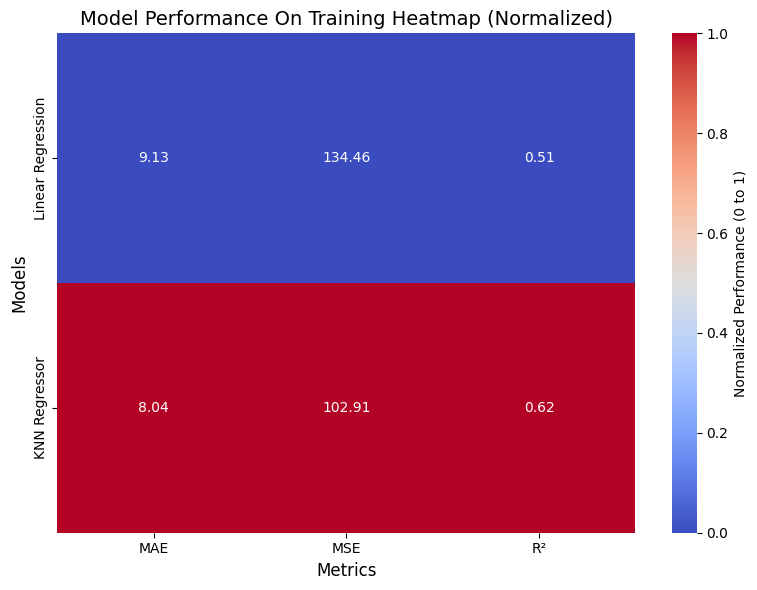

HOTTER IS BETTER !!


In [101]:
visualize_performance(LR_MAE, LR_MSE, LR_R2, KNN_MAE, KNN_MSE, KNN_R2, "Train")

In [102]:
LR_MAE, LR_MSE, LR_R2 = model_eval(LR_model, y_test, X_test, "Test", "Linear Regression")
KNN_MAE, KNN_MSE, KNN_R2 = model_eval(KNN_model, y_test, X_test, "Test", "KNN Regressor")

<Linear Regression Model|Test Data Evaluation>
Mean Absolute Error >> 9.47
Mean Squared Error >> 145.40
R-Squared Score >> 0.48


<KNN Regressor Model|Test Data Evaluation>
Mean Absolute Error >> 10.16
Mean Squared Error >> 164.94
R-Squared Score >> 0.41




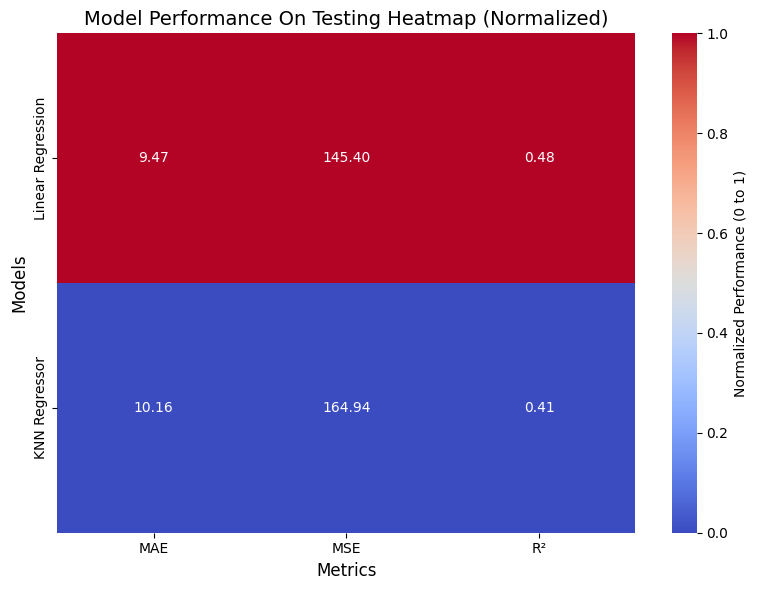

HOTTER IS BETTER !!


In [103]:
visualize_performance(LR_MAE, LR_MSE, LR_R2, KNN_MAE, KNN_MSE, KNN_R2, "Test")